In [ ]:
!pip install qiskit qiskit-aer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
import matplotlib.ticker as mticker

In [ ]:
t1_values = {
    "Low Radicals (Control)":   3.0,
    "Medium Radicals":          1.5,
    "High Radicals (Stressed)": 0.7,
}

tau_max    = 9.0
num_points = 25
delays     = np.linspace(0.0, tau_max, num_points)

n_shots_single = 4096
n_shots_ens    = 2048
n_trials_single = 20

### Single NV center

### Single runs

In [ ]:
def decay_model(t, T1, A, C):
    return A * np.exp(-t / T1) + C # the general form, but we can use A = -1 and C = 1 and only fit for T1

In [ ]:
def simulate_single_nv_qiskit(T1_ms, delays_ms, n_shots=4096):
    sim = AerSimulator(method="density_matrix")
    P1_list = []

    for tau in delays_ms:
        gamma = 1.0 - np.exp(-tau / T1_ms)
        gamma = min(max(gamma, 0.0), 1.0)

        noise_model = NoiseModel()
        ad_error = amplitude_damping_error(gamma)
        noise_model.add_all_qubit_quantum_error(ad_error, ['id'])

        qc = QuantumCircuit(1, 1)
        qc.x(0)
        qc.id(0)
        qc.measure(0, 0)

        tqc = transpile(qc, sim, optimization_level=0)

        result = sim.run(tqc, noise_model=noise_model, shots=n_shots).result()
        counts = result.get_counts()
        p1 = counts.get('1', 0) / n_shots
        P1_list.append(p1)

    return np.array(P1_list)


single_results = {}

print("=== Single NV center (1 qubit) ===")
print(f"{'Condition':<25} | {'True T1 (ms)':>11} | {'Fitted T1 (ms)':>13} | {'Rel error (%)':>14}")
print("-" * 70)

for label, T1_true in t1_values.items():
    P_data = simulate_single_nv_qiskit(
        T1_true, delays,
        n_shots=n_shots_single
    )

    A0   = P_data[0] - P_data[-1]
    C0   = P_data[-1]
    T1_0 = T1_true

    popt, _ = curve_fit(decay_model, delays, P_data,
                        p0=[T1_0, A0, C0])
    T1_hat, A_hat, C_hat = popt
    rel_err = 100.0 * (T1_hat - T1_true) / T1_true

    single_results[label] = {
        "T1_true": T1_true,
        "T1_hat":  T1_hat,
        "P_data":  P_data,
        "P_fit":   decay_model(delays, *popt),
    }

    print(f"{label:<25} | {T1_true:11.2f} | {T1_hat:13.4f} | {rel_err:14.2f}")

=== Single NV center (1 qubit) ===
Condition                 | True T1 (ms) | Fitted T1 (ms) |  Rel error (%)
----------------------------------------------------------------------
Low Radicals (Control)    |        3.00 |        3.0215 |           0.72
Medium Radicals           |        1.50 |        1.5370 |           2.47
High Radicals (Stressed)  |        0.70 |        0.7010 |           0.15


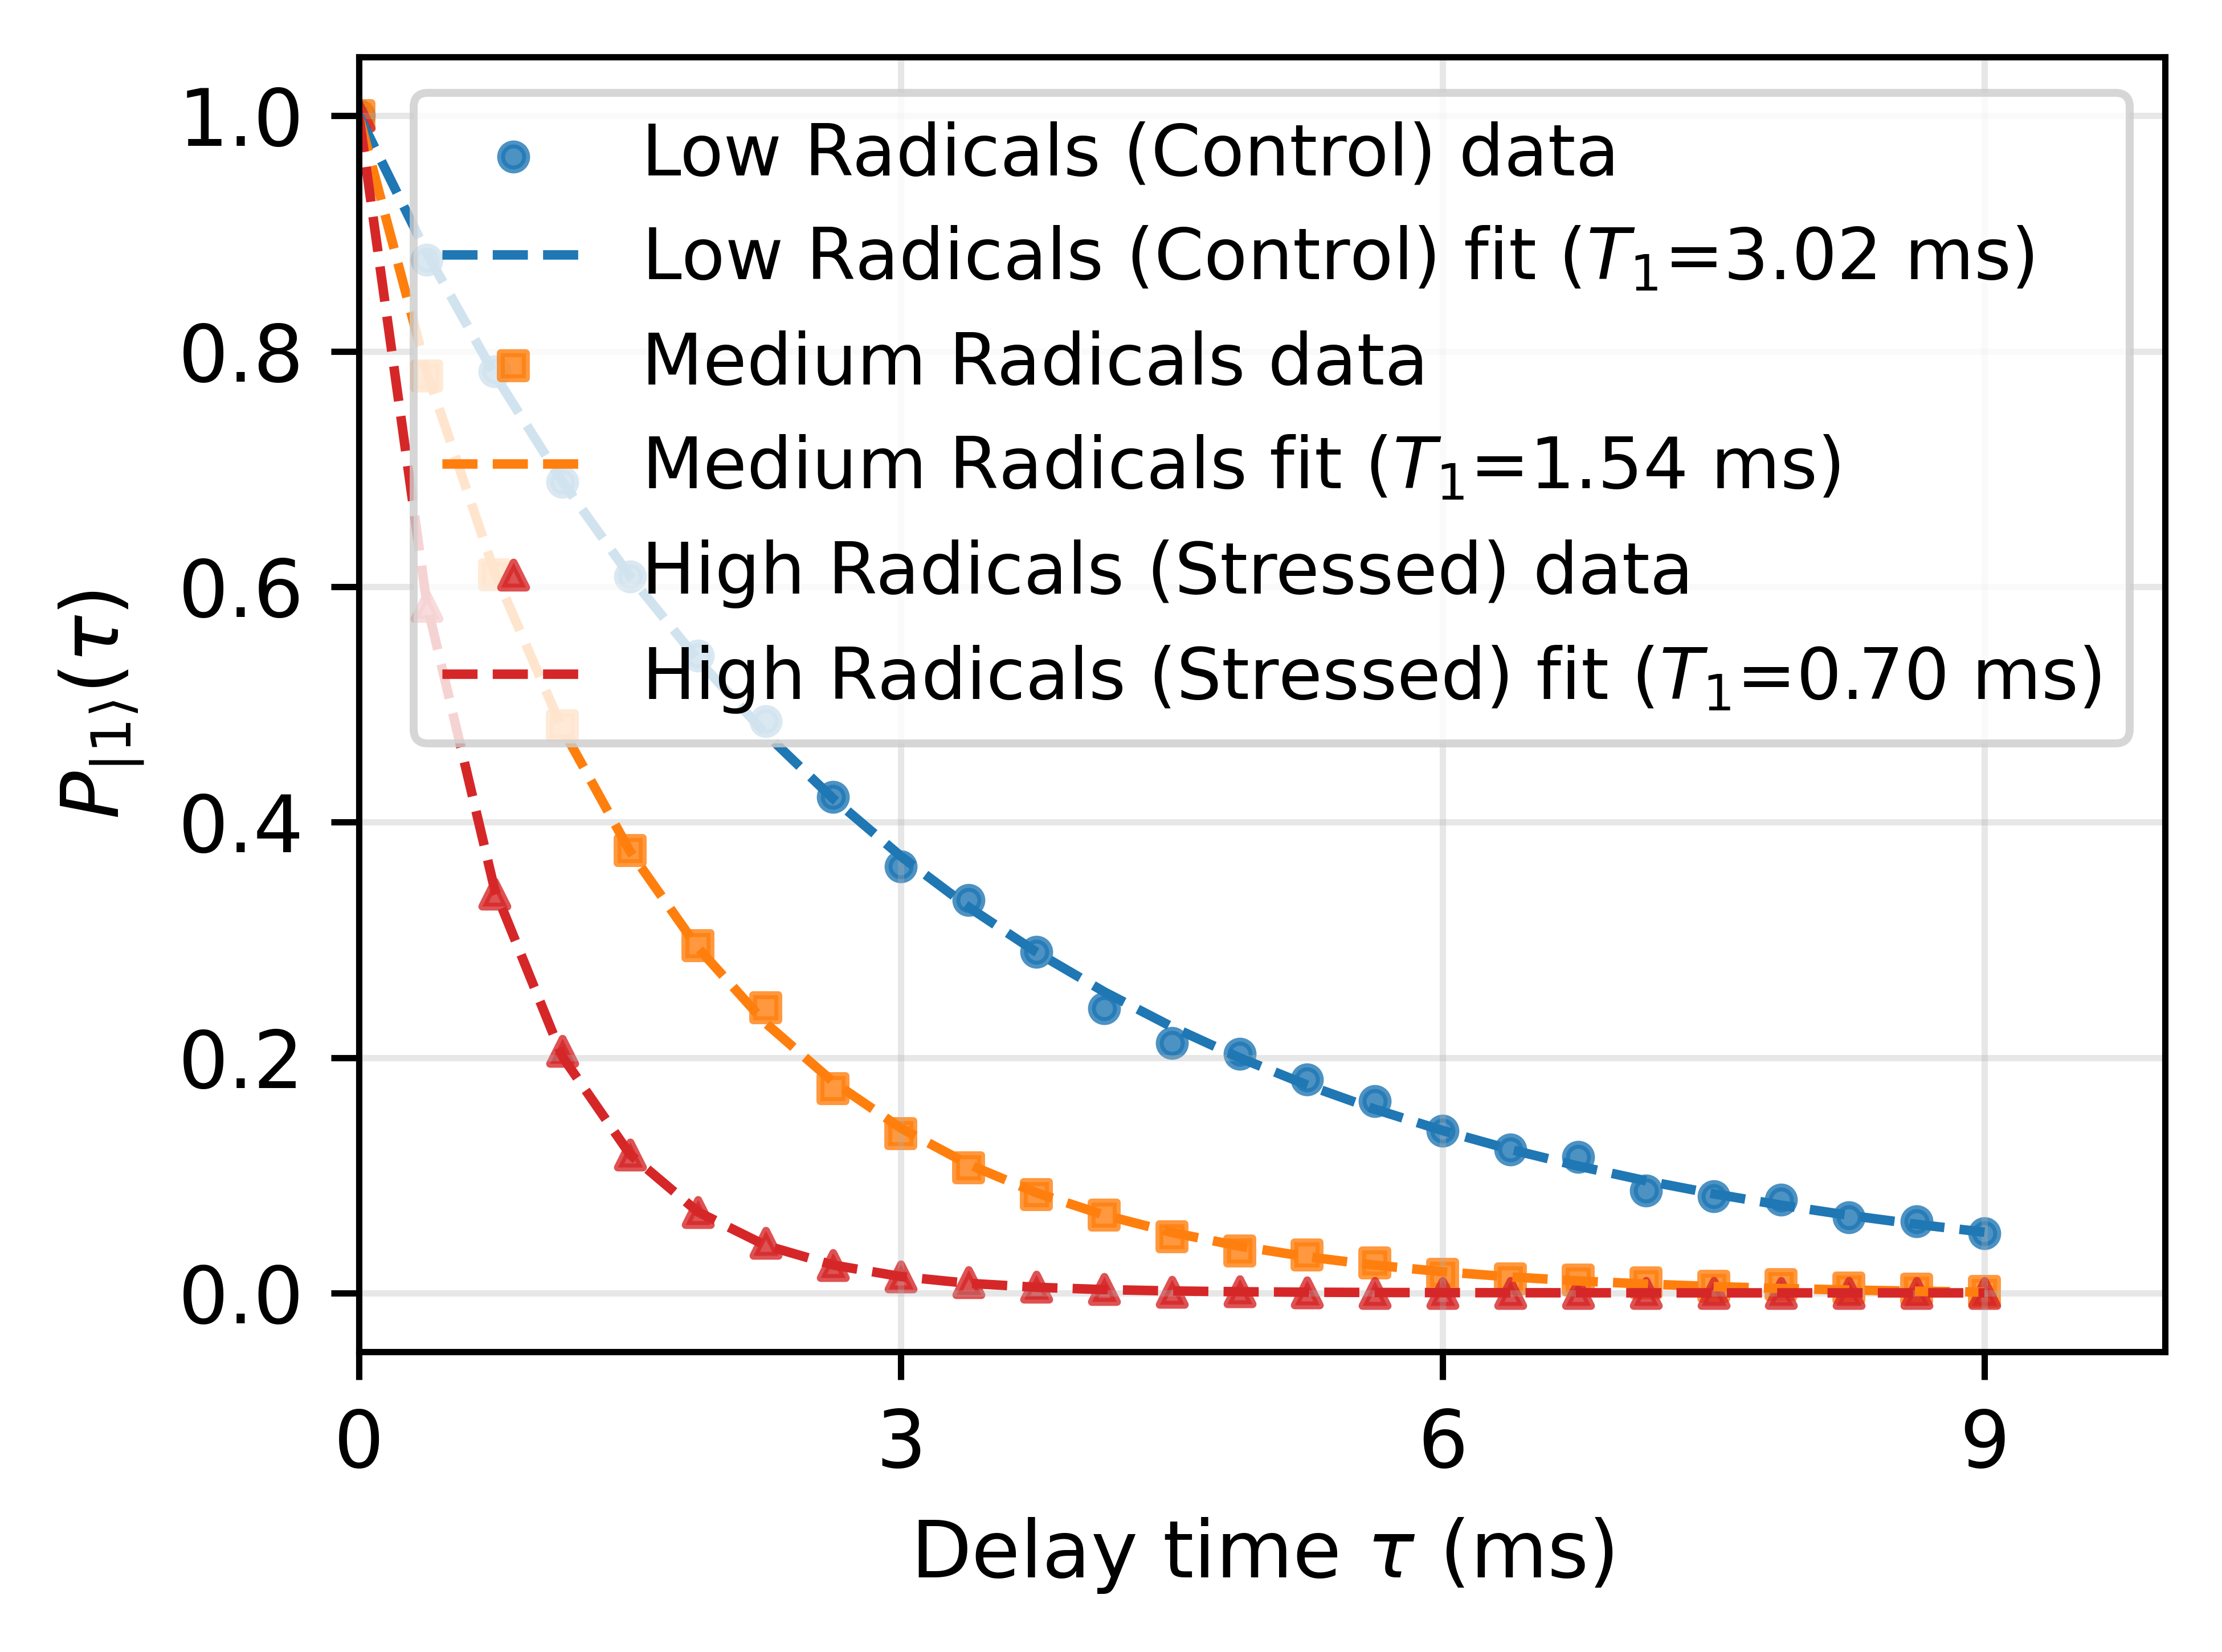

In [ ]:
plt.figure(figsize=(4, 3), dpi=1000)

colors  = ["tab:blue", "tab:orange", "tab:red"]
markers = ["o", "s", "^"]

for (label, color, marker) in zip(t1_values.keys(), colors, markers):
    res = single_results[label]
    plt.scatter(
        delays, res["P_data"],
        s=10, alpha=0.8,
        color=color, marker=marker,
        label=f"{label} data"
    )
    plt.plot(
        delays, res["P_fit"],
        linestyle="--", linewidth=1.2,
        color=color,
        label=f"{label} fit ($T_1$={res['T1_hat']:.2f} ms)"
    )

plt.xlabel(r"Delay time $\tau$ (ms)")
plt.ylabel(r"$P_{|1\rangle}(\tau)$")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

plt.xlim(0.0, tau_max+1)
plt.xticks([0, 3, 6, 9])

plt.tight_layout()
plt.savefig("fig_single_nv.png")
plt.show()

### Multiple runs

=== Single NV center (1 qubit) ===
Condition                 | True T1 (ms) | Mean T1_hat (ms) |  Std T1_hat (ms) |  Rel error (%)
------------------------------------------------------------------------------------------
Low Radicals (Control)    |        3.00 |           2.9985 |           0.0257 |          -0.05
Medium Radicals           |        1.50 |           1.4941 |           0.0130 |          -0.39
High Radicals (Stressed)  |        0.70 |           0.7000 |           0.0063 |           0.00


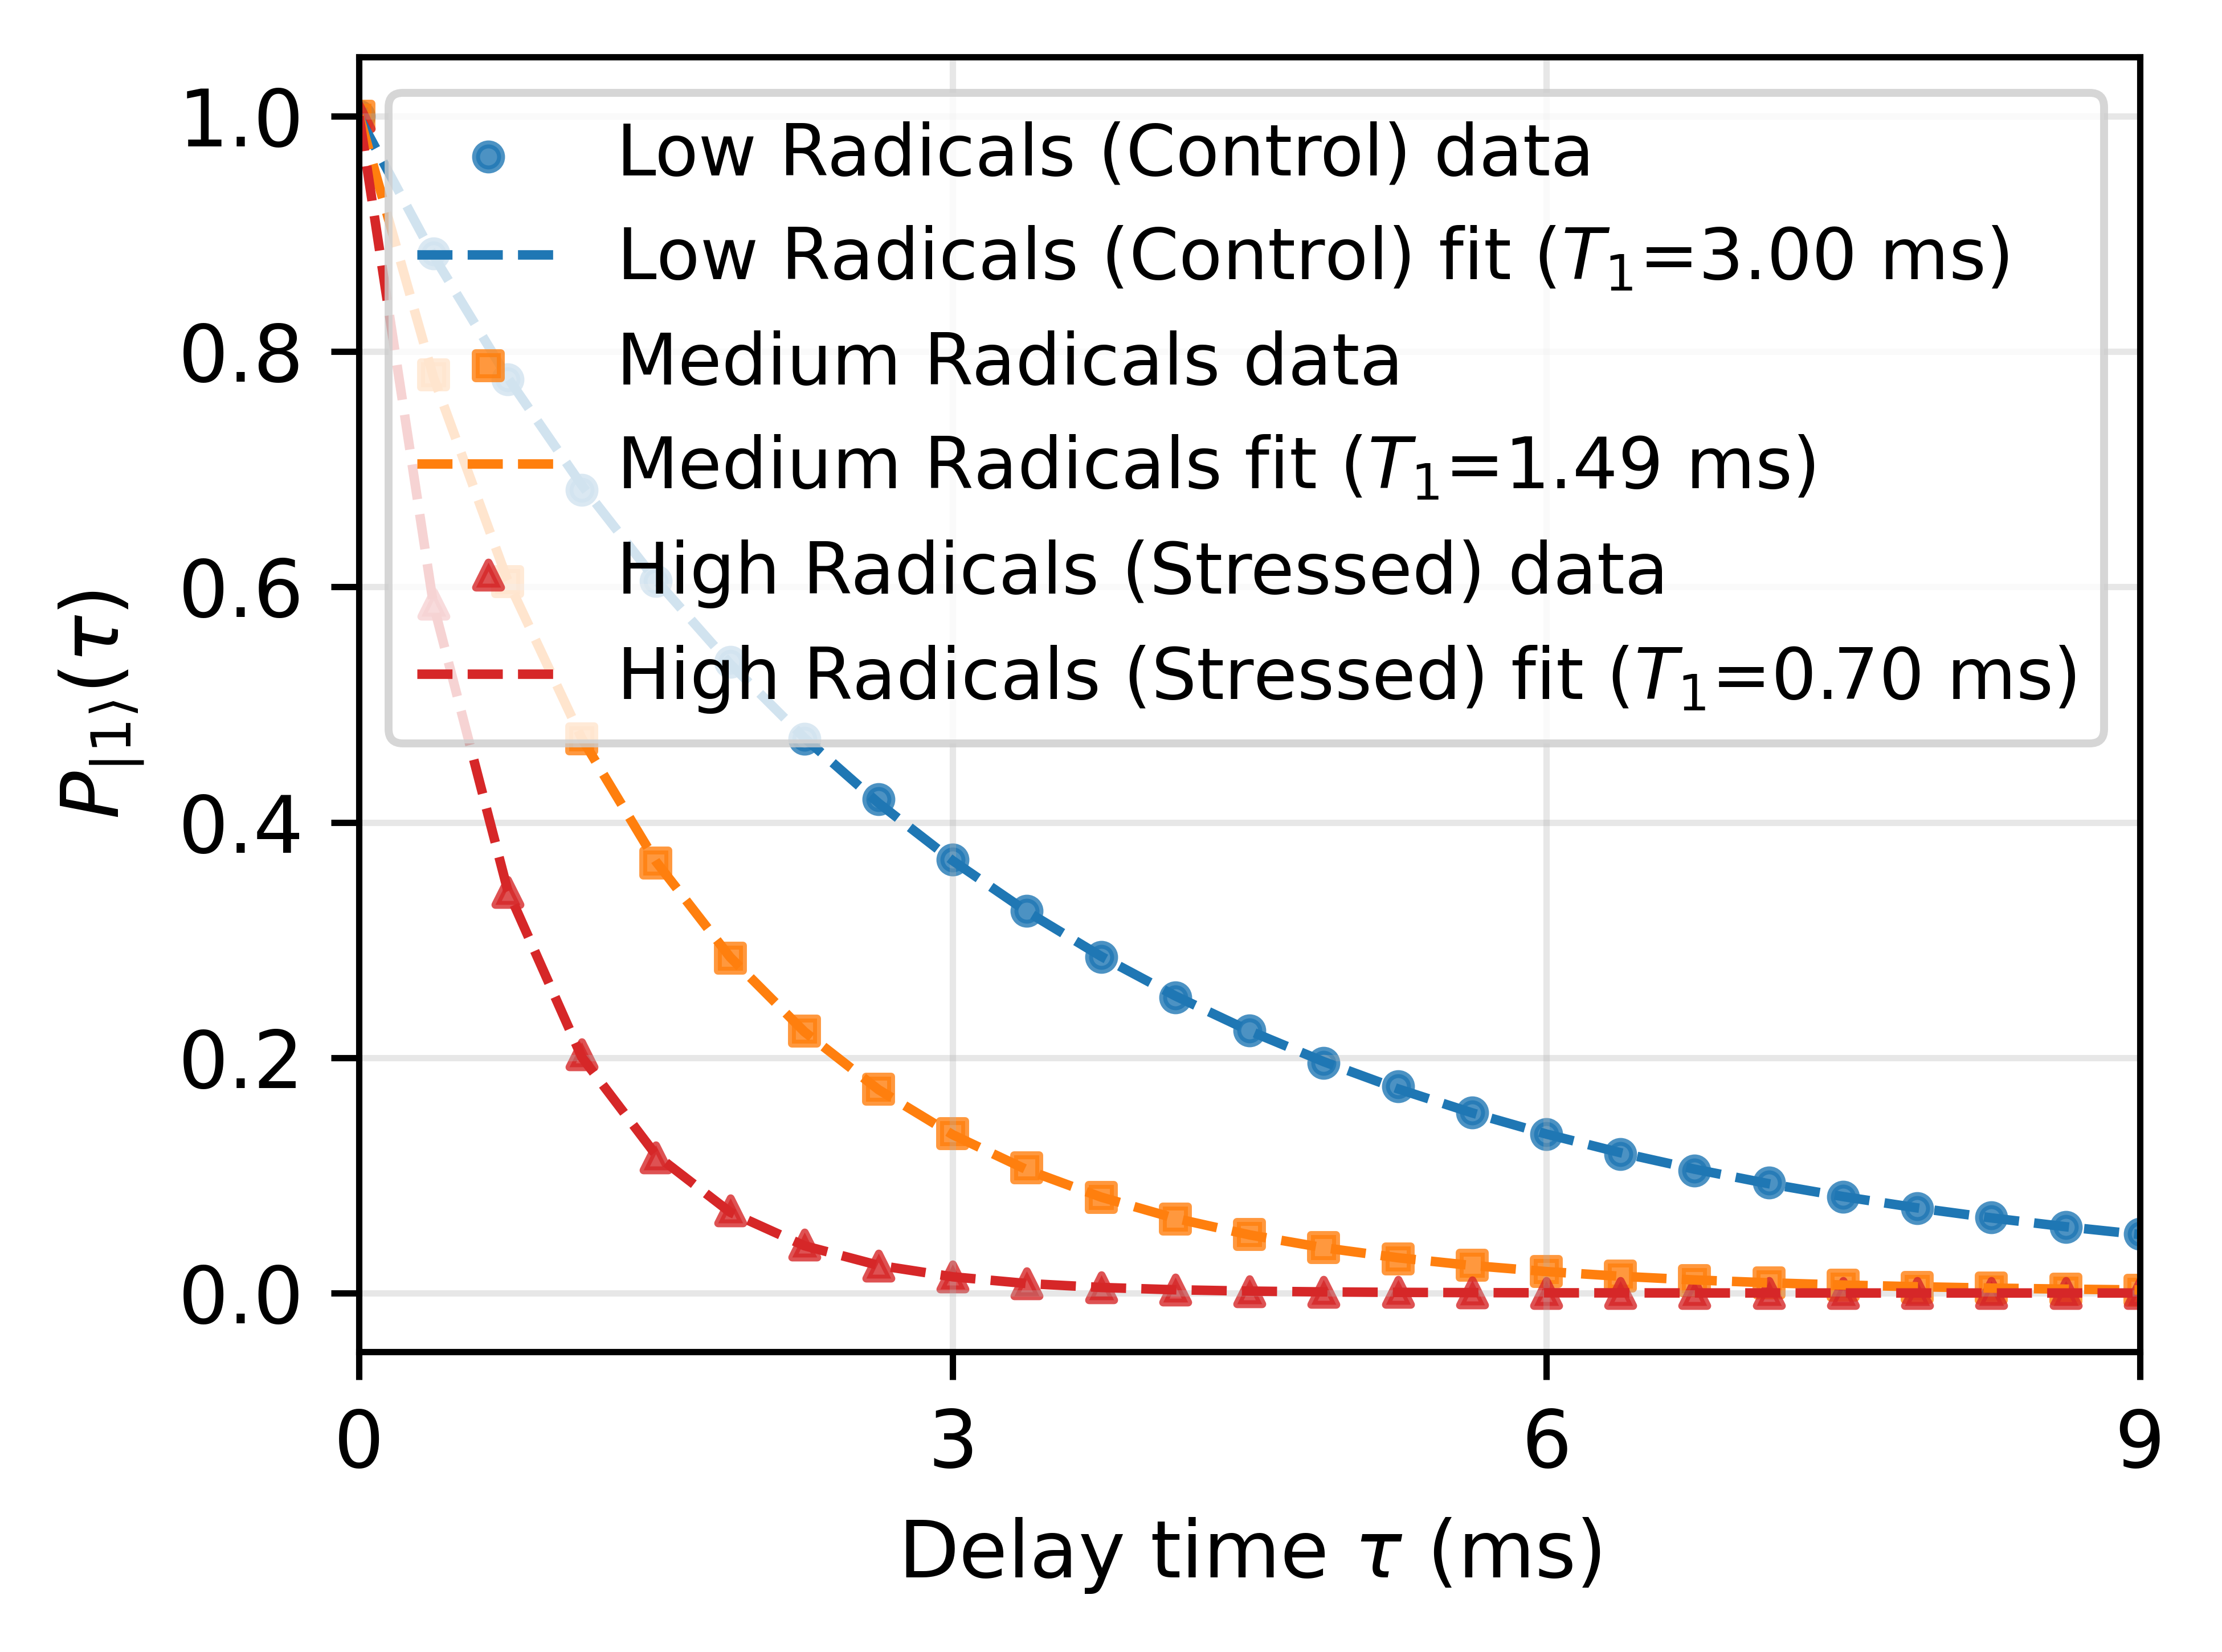

In [ ]:
# ============================================================
# 1) Single NV center (1 qubit) with multiple runs
# ============================================================
def simulate_single_nv_qiskit(T1_ms, delays_ms, n_shots=4096):
    sim = AerSimulator(method="density_matrix")
    P1_list = []

    for tau in delays_ms:
        gamma = 1.0 - np.exp(-tau / T1_ms)
        gamma = min(max(gamma, 0.0), 1.0)

        noise_model = NoiseModel()
        ad_error = amplitude_damping_error(gamma)
        noise_model.add_all_qubit_quantum_error(ad_error, ['id'])

        qc = QuantumCircuit(1, 1)
        qc.x(0)
        qc.id(0)
        qc.measure(0, 0)

        tqc = transpile(qc, sim, optimization_level=0)
        result = sim.run(tqc, noise_model=noise_model, shots=n_shots).result()
        counts = result.get_counts()
        p1 = counts.get('1', 0) / n_shots
        P1_list.append(p1)

    return np.array(P1_list)


single_results = {}

print("=== Single NV center (1 qubit) ===")
print(f"{'Condition':<25} | {'True T1 (ms)':>11} | {'Mean T1_hat (ms)':>16} | "
      f"{'Std T1_hat (ms)':>16} | {'Rel error (%)':>14}")
print("-" * 90)

for label, T1_true in t1_values.items():
    T1_hats    = []
    all_P_data = []

    # --- Monte Carlo over trials ---
    for _ in range(n_trials_single):
        P_data = simulate_single_nv_qiskit(
            T1_true, delays,
            n_shots=n_shots_single
        )

        # fit this run
        A0   = P_data[0] - P_data[-1]
        C0   = P_data[-1]
        T1_0 = T1_true

        popt, _ = curve_fit(decay_model, delays, P_data,
                            p0=[T1_0, A0, C0])
        T1_hat, A_hat, C_hat = popt
        T1_hats.append(T1_hat)
        all_P_data.append(P_data)

    T1_hats    = np.array(T1_hats)
    mean_T1    = np.mean(T1_hats)
    std_T1     = np.std(T1_hats)
    rel_err    = 100.0 * (mean_T1 - T1_true) / T1_true

    # use the mean curve for plotting
    P_mean = np.mean(all_P_data, axis=0)
    A0m    = P_mean[0] - P_mean[-1]
    C0m    = P_mean[-1]
    popt_mean, _ = curve_fit(decay_model, delays, P_mean,
                             p0=[T1_true, A0m, C0m])
    T1_fit_mean = popt_mean[0]
    P_fit_mean  = decay_model(delays, *popt_mean)

    single_results[label] = {
        "T1_true":    T1_true,
        "T1_mean":    mean_T1,
        "T1_std":     std_T1,
        "P_data":     P_mean,
        "P_fit":      P_fit_mean,
    }

    print(f"{label:<25} | {T1_true:11.2f} | {mean_T1:16.4f} | "
          f"{std_T1:16.4f} | {rel_err:14.2f}")


# --- Single-NV curves: figsize=(4,3), dpi=1000, NO title ---
plt.figure(figsize=(4, 3), dpi=1000)

colors  = ["tab:blue", "tab:orange", "tab:red"]
markers = ["o", "s", "^"]

for (label, color, marker) in zip(t1_values.keys(), colors, markers):
    res = single_results[label]
    plt.scatter(
        delays, res["P_data"],
        s=10, alpha=0.8,
        color=color, marker=marker,
        label=f"{label} data"
    )
    plt.plot(
        delays, res["P_fit"],
        linestyle="--", linewidth=1.2,
        color=color,
        label=(f"{label} fit ($T_1$={res['T1_mean']:.2f} ms)")
    )

plt.xlabel(r"Delay time $\tau$ (ms)")
plt.ylabel(r"$P_{|1\rangle}(\tau)$")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

plt.xlim(0.0, tau_max)
plt.xticks([0, 3, 6, 9])

plt.tight_layout()
plt.savefig("fig_single_nv.png")
plt.show()


### Homogeneous ensembles

In [ ]:
def simulate_ensemble_qiskit(T1_ms, delays_ms,
                             n_qubits=4,
                             n_shots=2048):
    sim = AerSimulator(method="density_matrix")
    P1_list = []

    for tau in delays_ms:
        gamma = 1.0 - np.exp(-tau / T1_ms)
        gamma = min(max(gamma, 0.0), 1.0)

        noise_model = NoiseModel()
        ad_error = amplitude_damping_error(gamma)
        noise_model.add_all_qubit_quantum_error(ad_error, ['id'])

        qc = QuantumCircuit(n_qubits, n_qubits)
        qc.x(range(n_qubits))
        qc.id(range(n_qubits))
        qc.measure(range(n_qubits), range(n_qubits))

        tqc = transpile(qc, sim, optimization_level=0)

        result = sim.run(tqc, noise_model=noise_model,
                         shots=n_shots).result()
        counts = result.get_counts()

        total_ones    = 0
        total_samples = n_qubits * n_shots

        for bitstring, c in counts.items():
            total_ones += bitstring.count('1') * c

        P1_avg = total_ones / total_samples
        P1_list.append(P1_avg)

    return np.array(P1_list)

In [ ]:
condition_for_scaling = "Medium Radicals"
T1_true = t1_values[condition_for_scaling]

N_qubits_list = [1, 2, 4, 8]
n_trials = 20

In [ ]:
scaling_stats = []
print("\n=== Homogeneous ensembles: SQL scaling (Qiskit) ===")
print(f"Condition: {condition_for_scaling}, true T1 = {T1_true} ms")
print(f"{'N_NV':>6} | {'mean T1_hat (ms)':>16} | {'std T1_hat (ms)':>16} | {'rel std (%)':>11}")
print("-" * 70)

for N in N_qubits_list:
    T1_hats = []

    for _ in range(n_trials):
        P_data = simulate_ensemble_qiskit(
            T1_true, delays,
            n_qubits=N,
            n_shots=n_shots_ens
        )

        A0   = P_data[0] - P_data[-1]
        C0   = P_data[-1]
        T1_0 = T1_true

        popt, _ = curve_fit(decay_model, delays, P_data,
                            p0=[T1_0, A0, C0])
        T1_hat, A_hat, C_hat = popt
        T1_hats.append(T1_hat)

    T1_hats = np.array(T1_hats)
    mean_T1 = np.mean(T1_hats)
    std_T1  = np.std(T1_hats)
    rel_std = 100.0 * std_T1 / T1_true

    scaling_stats.append((N, mean_T1, std_T1, rel_std))
    print(f"{N:6d} | {mean_T1:16.4f} | {std_T1:16.4f} | {rel_std:11.2f}")



=== Homogeneous ensembles: SQL scaling (Qiskit) ===
Condition: Medium Radicals, true T1 = 1.5 ms
  N_NV | mean T1_hat (ms) |  std T1_hat (ms) | rel std (%)
----------------------------------------------------------------------
     1 |           1.5038 |           0.0154 |        1.03
     2 |           1.5064 |           0.0108 |        0.72
     4 |           1.4963 |           0.0079 |        0.52
     8 |           1.4999 |           0.0067 |        0.45


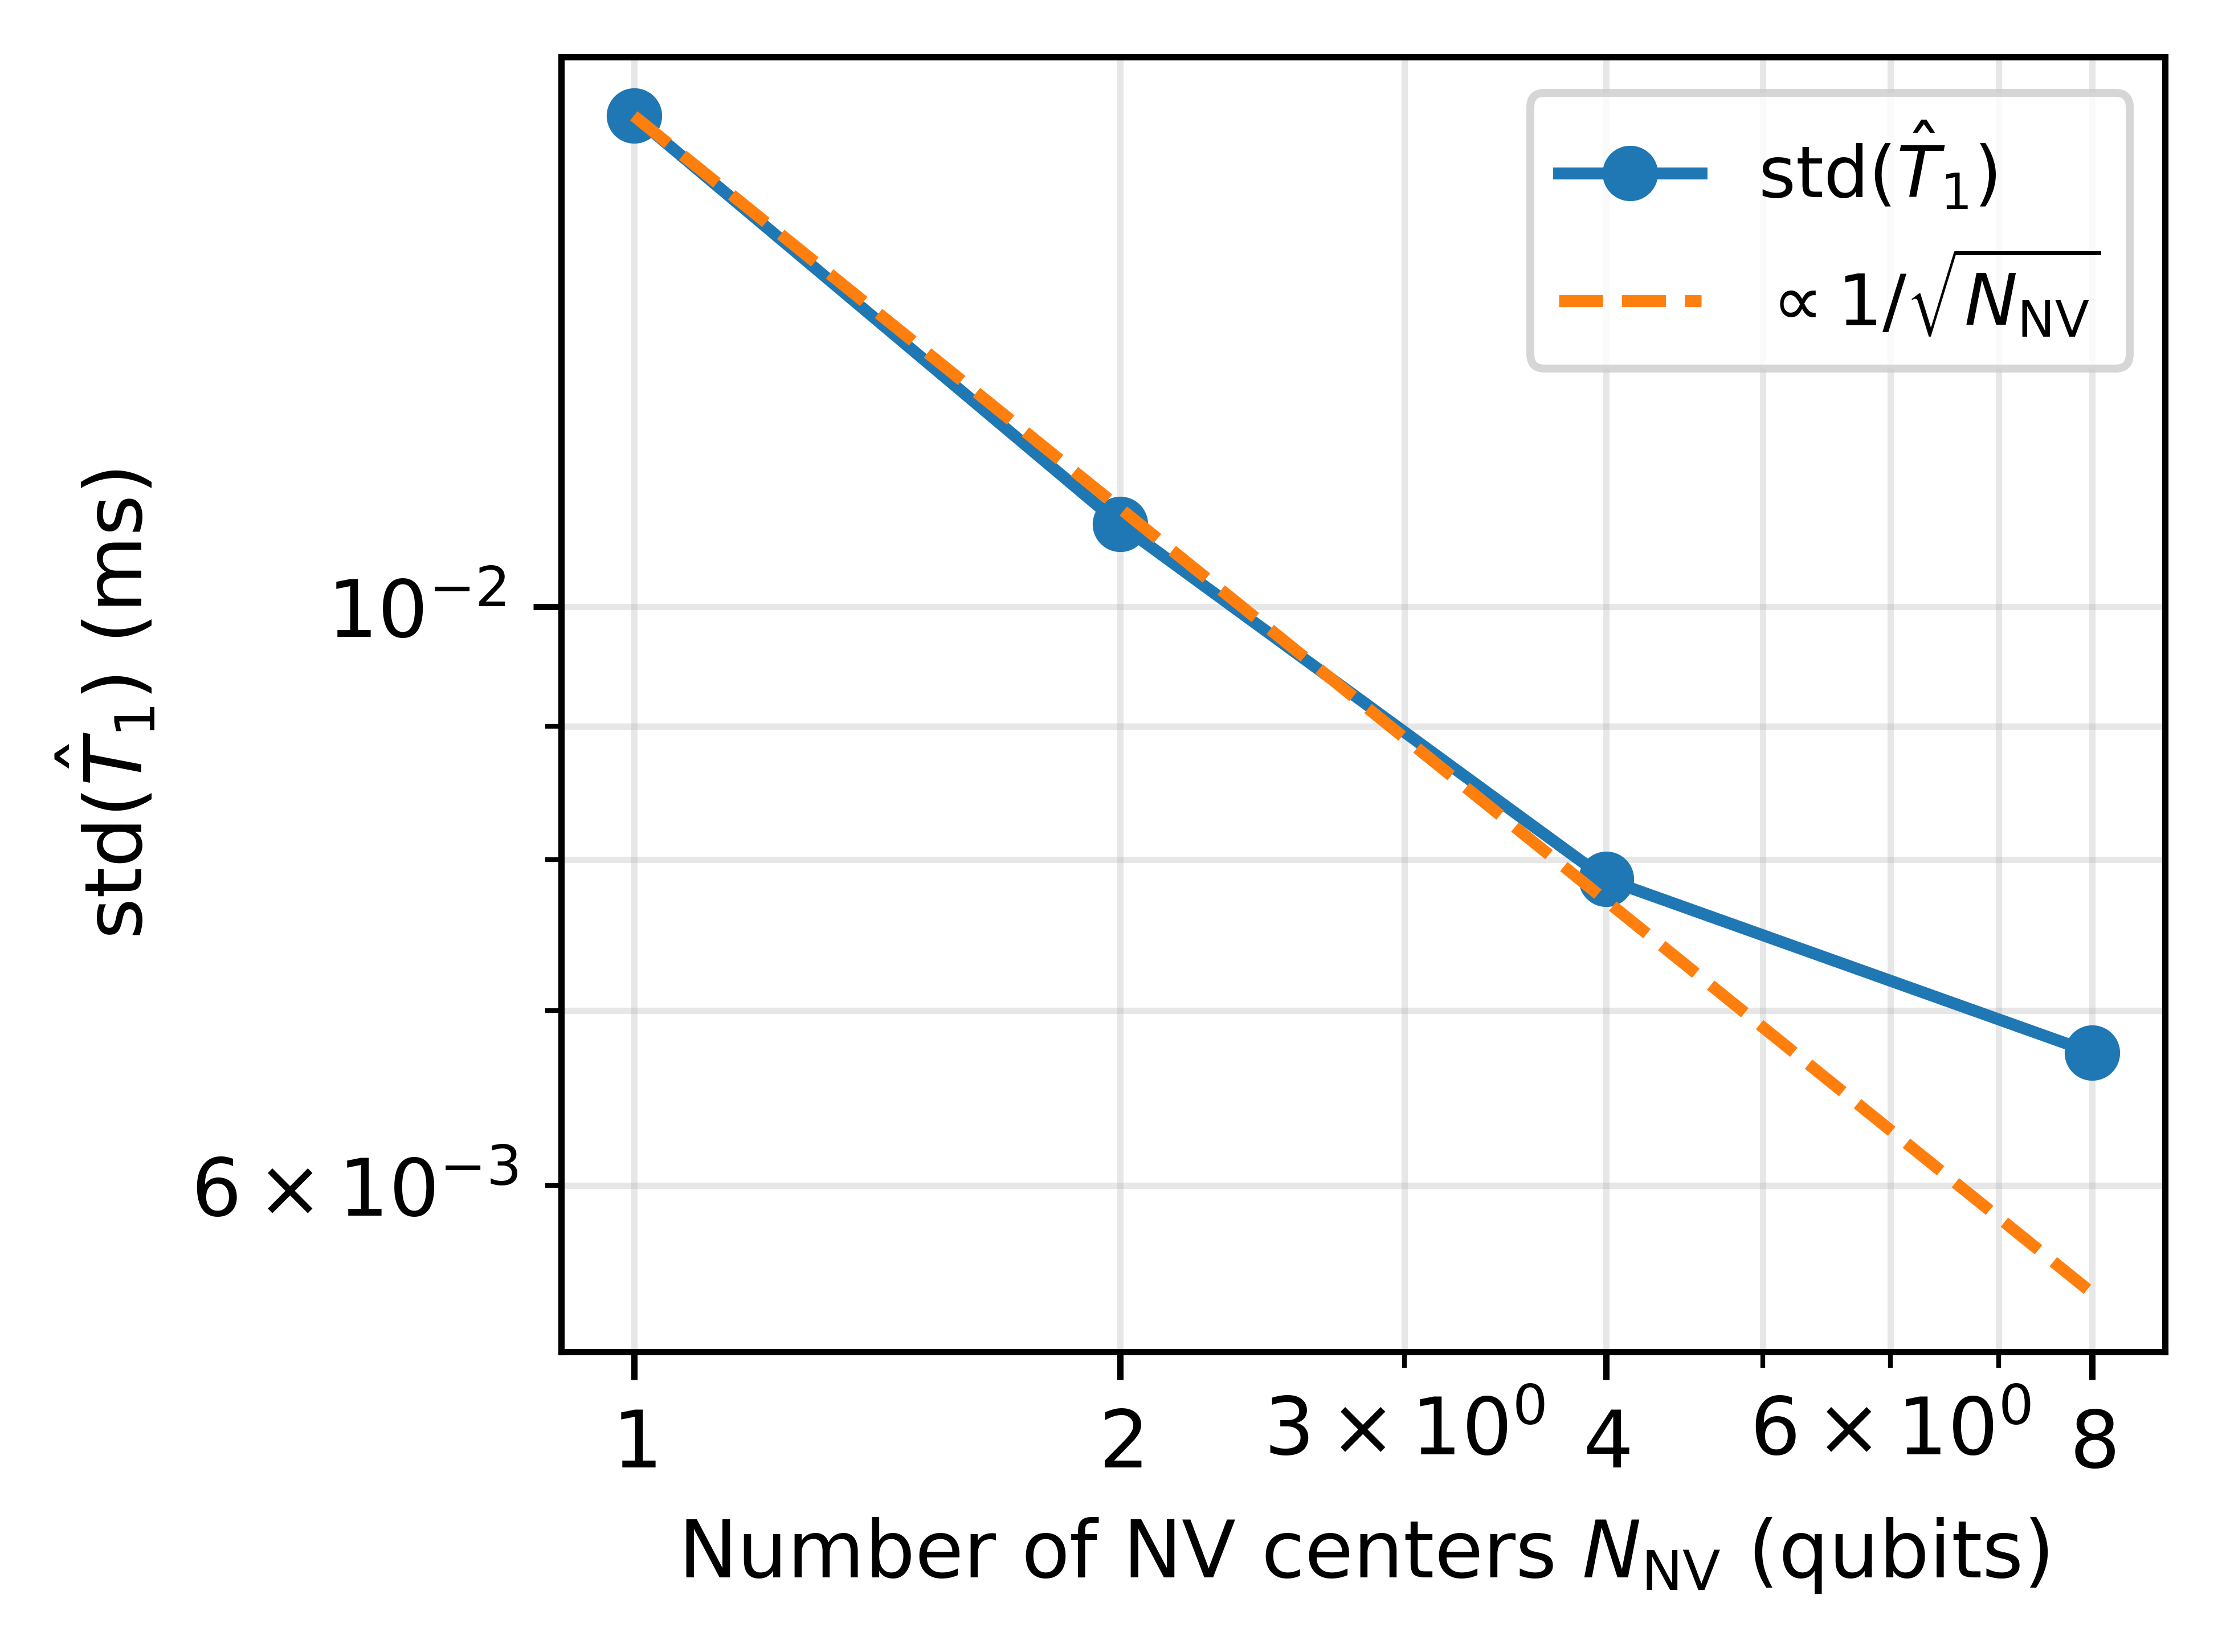

In [ ]:
scaling_stats = np.array(scaling_stats)
N_vals   = scaling_stats[:, 0]
std_vals = scaling_stats[:, 2]

fig, ax = plt.subplots(figsize=(4, 3), dpi=1000)

ax.loglog(N_vals, std_vals, "o-",
          label=r"$\mathrm{std}(\hat{T}_1)$")

ref = std_vals[0] * np.sqrt(N_vals[0] / N_vals)
ax.loglog(N_vals, ref, "--", label=r"$\propto 1/\sqrt{N_\mathrm{NV}}$")

ax.set_xlabel(r"Number of NV centers $N_\mathrm{NV}$ (qubits)")
ax.set_ylabel(r"$\mathrm{std}(\hat{T}_1)$ (ms)")
ax.grid(True, which="both", alpha=0.3)
ax.legend(fontsize=9)

# --- fix overlapping x-axis labels ---
ax.set_xticks(N_vals)                         # only tick at 1,2,4,8
ax.set_xticklabels([r"$1$", r"$2$", r"$4$", r"$8$"])  # clean labels

plt.tight_layout()
plt.savefig("fig_nv_ensemble_sql.png")
plt.show()